Steps in this notebook.
1. Load libraries and data files
2. Define modeling function to subset the data for a given objective
3. Compare across audiences for each campaign type (Cultivation, Engagement, and Fundraising)

# load libraries and init

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

np.random.seed(67)

In [2]:
data = pd.read_csv('sample data files/input_for_step_3b.csv')

In [3]:
emotions_list = ['admiration', 'amusement', 'anger', 'annoyance', 'approval',
'caring', 'confusion', 'curiosity', 'desire',
'disappointment',
'disapproval',
'disgust',
'embarrassment',
'excitement',
'fear',
'gratitude',
'grief',
'joy',
'love',
'nervousness',
'optimism',
'pride',
'realization',
'relief',
'remorse',
'sadness',
'surprise',
'neutral']

# Preprocessing

## removing emails sent < 100

In [4]:
data.shape

(3363, 65)

In [5]:
data = data[data.emails_sent > 100]

In [6]:
data.shape

(3078, 65)

In [7]:
data.month.value_counts()

12    479
6     367
3     307
11    285
5     282
7     234
8     219
2     213
4     202
10    181
1     178
9     131
Name: month, dtype: int64

## creating target vars for classification model

### Creating weighted average of funnel metrics to balance emails sent over row count

In [8]:
data.Open_Rate_nw.mean()

0.2348876301250677

In [9]:
weighted_open_rate = sum(data.Open_Rate_nw * (data.emails_sent / sum(data.emails_sent)))
weighted_open_rate

0.1964780075307547

In [10]:
data.Click_Rate_nw.mean()

0.006445561516712708

In [11]:
weighted_click_rate = sum(data.Click_Rate_nw * (data.emails_sent / sum(data.emails_sent)))
weighted_click_rate

0.00345567291706645

In [12]:
data.Donation_Rate_nw.mean()

0.0009524554666733956

In [13]:
weighted_donation_rate = sum(data.Donation_Rate_nw * (data.emails_sent / sum(data.emails_sent)))
weighted_donation_rate

nan

In [14]:
filtered_for_donations = data[data.gifts > 0 ]
filtered_for_donations.shape

(2244, 65)

In [15]:
filtered_for_donations.Donation_Rate_nw.mean()

0.001246596125499003

In [16]:
weighted_donation_rate = sum(filtered_for_donations.Donation_Rate_nw * (filtered_for_donations.emails_sent / sum(filtered_for_donations.emails_sent)))
weighted_donation_rate

0.000651408661784732

### creating target vars greated than 15-20% of weighted average, based on EDA

In [17]:
data['target_for_opens'] = np.where(data.Open_Rate_nw > (weighted_open_rate * 1.25),1,0)
data['target_for_clicks'] = np.where(data.Click_Rate_nw > (weighted_click_rate * 1.25),1,0)
data['target_for_donations'] = np.where(data.Donation_Rate_nw > (weighted_donation_rate * 1.25),1,0)

In [18]:
print(data.target_for_opens.sum(), data.target_for_clicks.sum(), data.target_for_opens.sum())

1286 1179 1286


In [19]:
print(data.target_for_opens.sum()/len(data), data.target_for_clicks.sum()/len(data), data.target_for_opens.sum()/len(data))

0.41780376868096164 0.3830409356725146 0.41780376868096164


In [20]:
pd.crosstab(data.top_factor_label, data.target_for_opens, normalize='index')

target_for_opens,0,1
top_factor_label,,
Approval,0.544218,0.455782
Caring,0.683824,0.316176
Curiousity,0.634845,0.365155
Desire,0.680000,0.320000
Excitement,0.461957,0.538043
Gratitude,0.515528,0.484472
Neutral,0.555388,0.444612
Sadness,0.641892,0.358108


In [21]:
pd.crosstab(data.top_factor_label, data.target_for_clicks, normalize='index')

target_for_clicks,0,1
top_factor_label,,
Approval,0.659864,0.340136
Caring,0.676471,0.323529
Curiousity,0.546539,0.453461
Desire,0.712000,0.288000
Excitement,0.744565,0.255435
Gratitude,0.503106,0.496894
Neutral,0.580256,0.419744
Sadness,0.726351,0.273649


In [22]:
pd.crosstab(data.top_factor_label, data.target_for_donations, normalize='index')

target_for_donations,0,1
top_factor_label,,
Approval,0.826531,0.173469
Caring,0.691176,0.308824
Curiousity,0.787589,0.212411
Desire,0.624000,0.376000
Excitement,0.641304,0.358696
Gratitude,0.751553,0.248447
Neutral,0.734740,0.265260
Sadness,0.726351,0.273649


Generally this reveals a fairly even distribution across emotions for the target class. It suggests some patterns e.g. Excitment is good at driving opens but Gratitude is better at driving clicks, etc. 

We will also filter this across audiences and objective to find more specific patterns. 

# Building basic 'rollup' model for all audiences

In [23]:
X = pd.concat([data[emotions_list], pd.get_dummies(data.top_factor_label)], axis=1)
X

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,surprise,neutral,Approval,Caring,Curiousity,Desire,Excitement,Gratitude,Neutral,Sadness
0,0.005720,0.000640,0.000410,0.001399,0.123966,0.179079,0.004212,0.021661,0.000603,0.000341,...,0.003115,0.475150,0,0,0,0,0,0,1,0
1,0.000136,0.000234,0.000102,0.002072,0.000493,0.000035,0.000561,0.000131,0.001767,0.002076,...,0.000143,0.969983,0,0,0,0,0,0,1,0
3,0.000073,0.000539,0.001494,0.000966,0.001029,0.001623,0.010058,0.003588,0.000433,0.132312,...,0.000938,0.004663,0,0,0,0,0,0,0,1
5,0.000042,0.000168,0.000039,0.000063,0.000290,0.000035,0.000079,0.001443,0.000134,0.000024,...,0.001081,0.002006,0,0,0,0,1,0,0,0
7,0.000042,0.000168,0.000039,0.000063,0.000290,0.000035,0.000079,0.001443,0.000134,0.000024,...,0.001081,0.002006,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3358,0.000844,0.000106,0.000268,0.000127,0.002425,0.165154,0.000646,0.000582,0.000300,0.000186,...,0.000139,0.815130,0,1,0,0,0,0,0,0
3359,0.000844,0.000106,0.000268,0.000127,0.002425,0.165154,0.000646,0.000582,0.000300,0.000186,...,0.000139,0.815130,0,1,0,0,0,0,0,0
3360,0.000844,0.000106,0.000268,0.000127,0.002425,0.165154,0.000646,0.000582,0.000300,0.000186,...,0.000139,0.815130,0,1,0,0,0,0,0,0
3361,0.000844,0.000106,0.000268,0.000127,0.002425,0.165154,0.000646,0.000582,0.000300,0.000186,...,0.000139,0.815130,0,1,0,0,0,0,0,0


In [24]:
Y_opens = data.target_for_opens
Y_clicks = data.target_for_clicks
Y_donations = data.target_for_donations

Note -- test between different classifiers (in appendix) identified Random Forest as the best performer

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [26]:
target_metrics = [Y_opens, Y_clicks, Y_donations]
target_metric_names = ['Y_opens', 'Y_clicks', 'Y_donations']

In [27]:
for i in range(len(target_metrics)):
    X_train, X_test, y_train, y_test = train_test_split(X, target_metrics[i], test_size=0.33, random_state=42)
    clf = make_pipeline(StandardScaler(), RandomForestClassifier())
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('for metric: ',target_metric_names[i])
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred)) #,target_names=target_metrics[i].unique()


for metric:  Y_opens
accuracy 0.8090551181102362
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       583
           1       0.81      0.72      0.76       433

    accuracy                           0.81      1016
   macro avg       0.81      0.80      0.80      1016
weighted avg       0.81      0.81      0.81      1016

for metric:  Y_clicks
accuracy 0.7125984251968503
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       622
           1       0.63      0.64      0.63       394

    accuracy                           0.71      1016
   macro avg       0.70      0.70      0.70      1016
weighted avg       0.71      0.71      0.71      1016

for metric:  Y_donations
accuracy 0.7381889763779528
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       743
           1       0.52      0.41      0.46       273

    accuracy                  

This shows that the tonality alone can predict outcomes 70-80% of the time. While that's not good enough on its own, this creates a strong foundation to build on and can also offer more precise results by audience and objective. (see below)

# Creating different models for each audience and objective

## correcting case and naming differences

In [28]:
data.Audience.value_counts()

Lapsed Donors     765
First Levels      556
Partners          468
Other             431
Non Donors        425
Field Partners    258
PNB               175
Name: Audience, dtype: int64

In [29]:
data['audience_new'] = data.Audience
data.audience_new = data.audience_new.str.replace('Field Partners', 'Partners', regex=True)
data.audience_new = data.audience_new.str.replace('PNB', 'Partners', regex=True)

In [30]:
data.audience_new.value_counts()

Partners         901
Lapsed Donors    765
First Levels     556
Other            431
Non Donors       425
Name: audience_new, dtype: int64

In [31]:
list_of_audiences = data.audience_new.unique()

In [32]:
data.category.value_counts()

Appeal            736
fundraising       595
Cultivation       572
Unknown           383
Fundraising       292
engagement        275
cultivation       130
Engagement         87
Rapid Response      8
Name: category, dtype: int64

In [33]:
data.category = data.category.str.title()

In [34]:
data.category.value_counts()

Fundraising       887
Appeal            736
Cultivation       702
Unknown           383
Engagement        362
Rapid Response      8
Name: category, dtype: int64

In [35]:
data.category = data.category.str.replace('Rapid Response', 'Fundraising', regex=True)

## Setting up some nested modeling scenarios

This is a derpy copy and paste job but there are a lot of possibilities here for making this code & viz more robust.

Things to note:
- cultivation campaigns are not meant to drive donations so are only focused on engagement KPI's (opens and clicks)
- Engagement campaigns are meant to drive non-fundraising action (e.g. signing a petition, attending a webinar, etc)

### Question 1: How do we re-engage Lapsed donors?

For this analysis subset we are looking at all 3 funnel metrics but subsetting among lapsed donors. 

In [36]:
data_slim = data[data.audience_new == 'Lapsed Donors']
X = pd.concat([data_slim[emotions_list], pd.get_dummies(data_slim.top_factor_label)], axis=1)

In [37]:
Y_opens = data_slim.target_for_opens
Y_clicks = data_slim.target_for_clicks
Y_donations = data_slim.target_for_donations

In [38]:
target_metrics = [Y_opens, Y_clicks, Y_donations]
target_metric_names = ['Y_opens', 'Y_clicks', 'Y_donations']

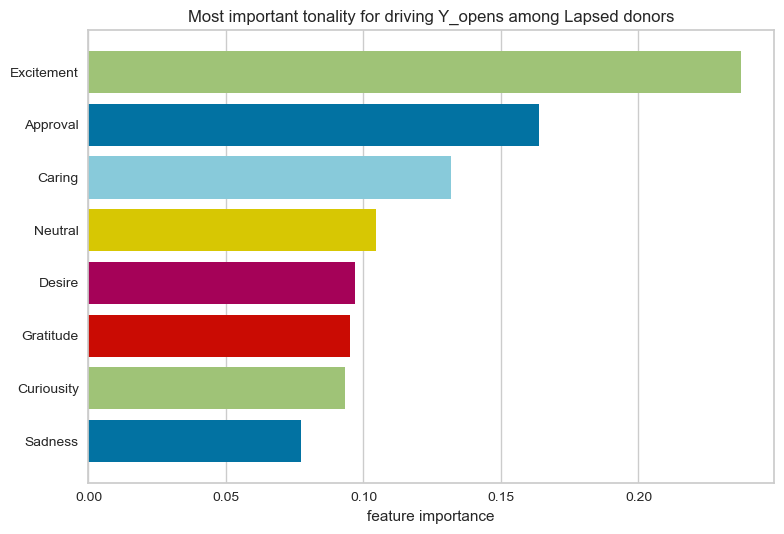

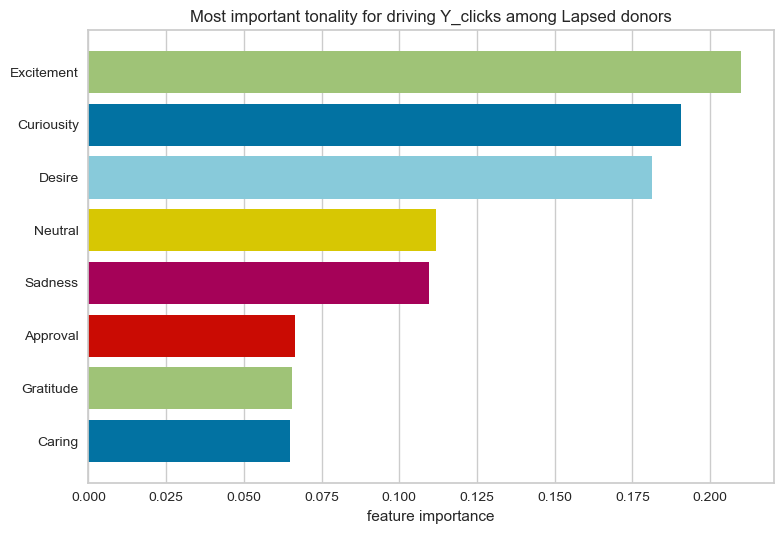

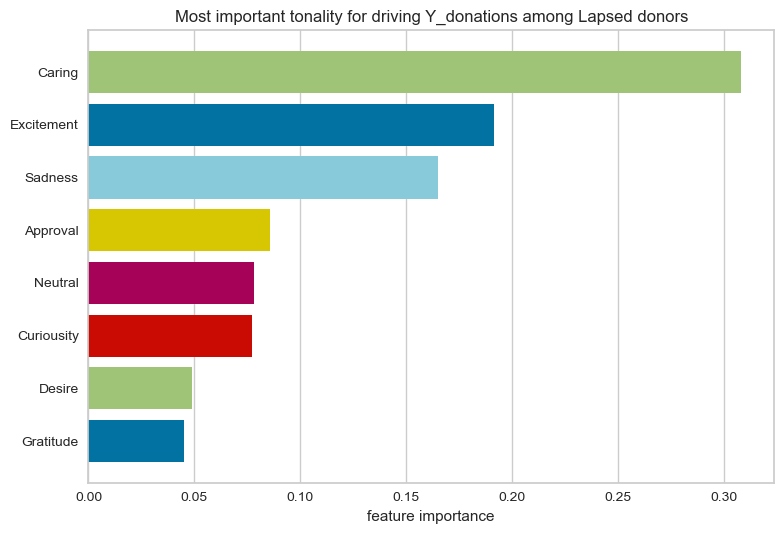

In [39]:
for i in range(len(target_metrics)):
    model = RandomForestClassifier()
    title_field="Most important tonality for driving "+str(target_metric_names[i]+" among Lapsed donors")
    viz = FeatureImportances(model, relative=False, title=title_field)
    viz.fit(pd.get_dummies(data_slim.top_factor_label), target_metrics[i])
    viz.show()



### Question 1: What is the best way to drive engagement with Cultivation Campaigns?

For this analysis we are looking across audiences and looking at open and click-through rate

In [40]:
data_slim = data[data.category == 'Cultivation']

In [41]:
list_of_audiences

array(['Other', 'Partners', 'First Levels', 'Lapsed Donors', 'Non Donors'],
      dtype=object)

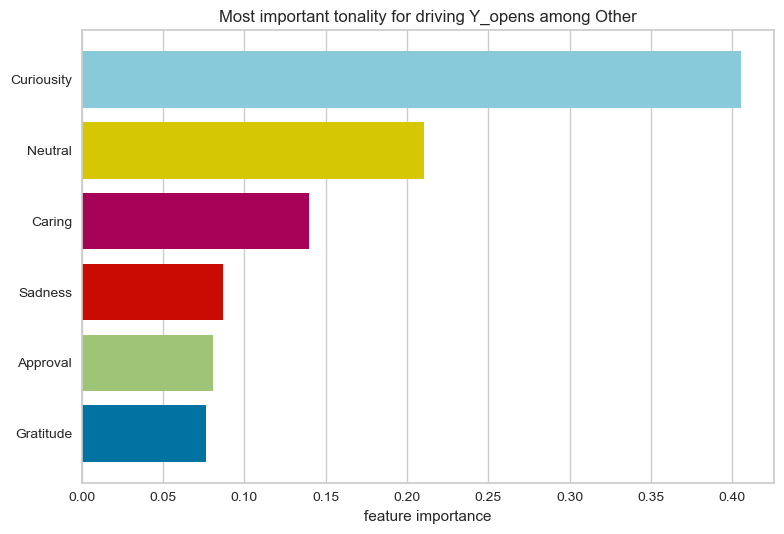

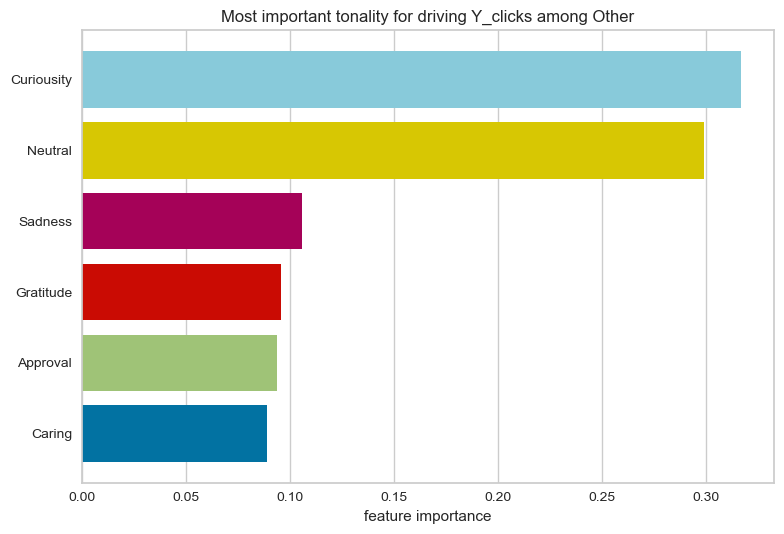

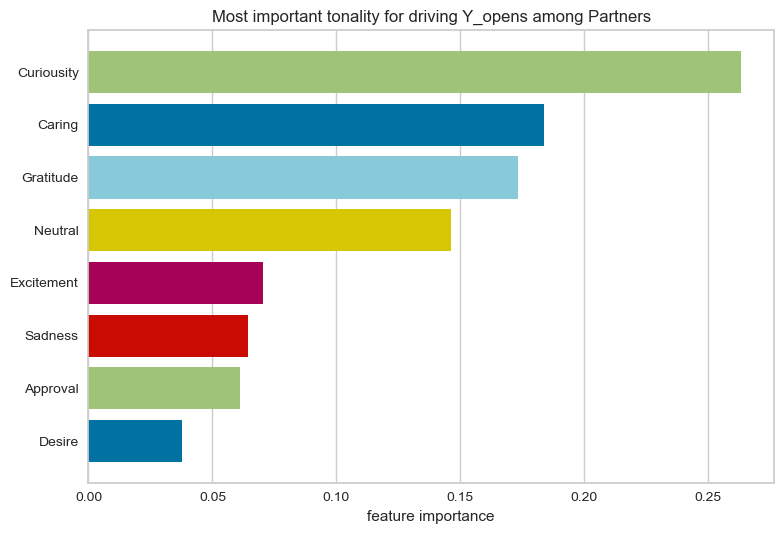

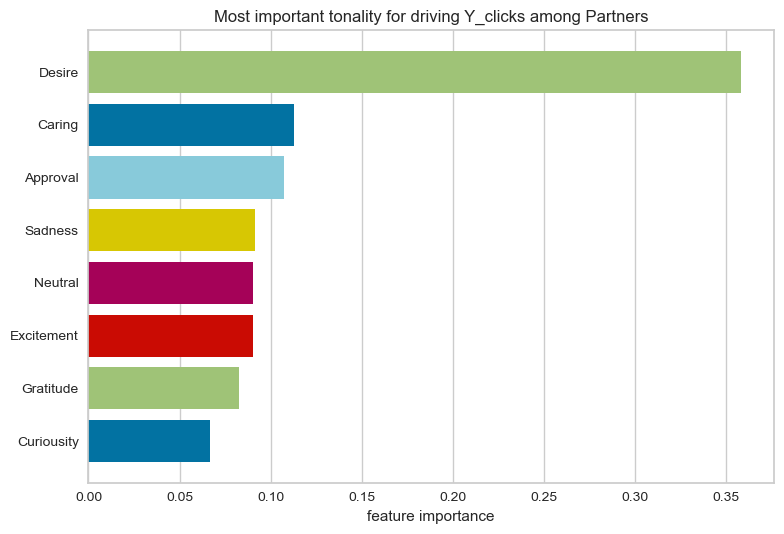

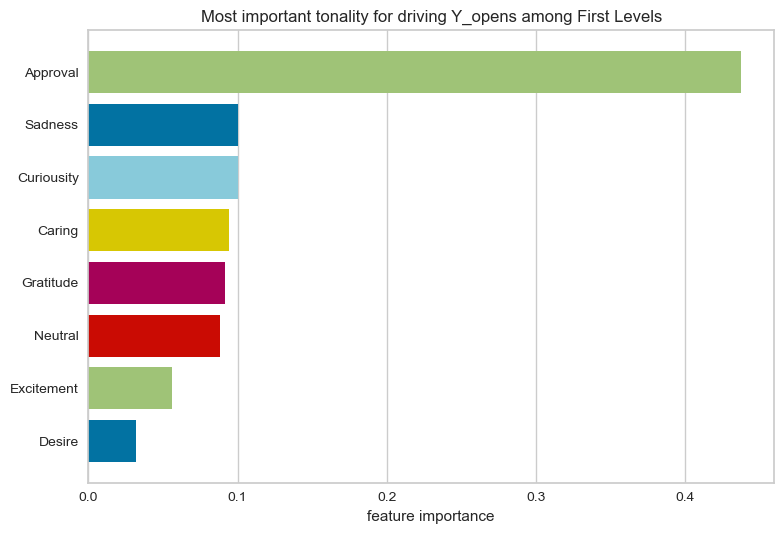

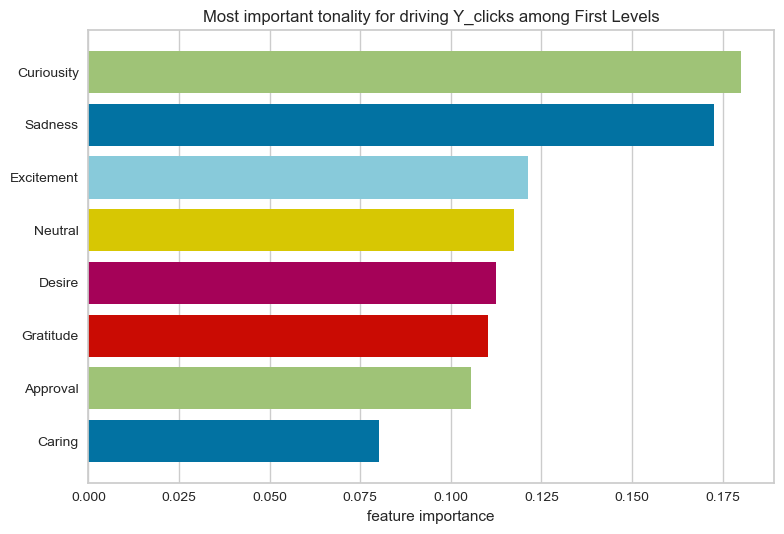

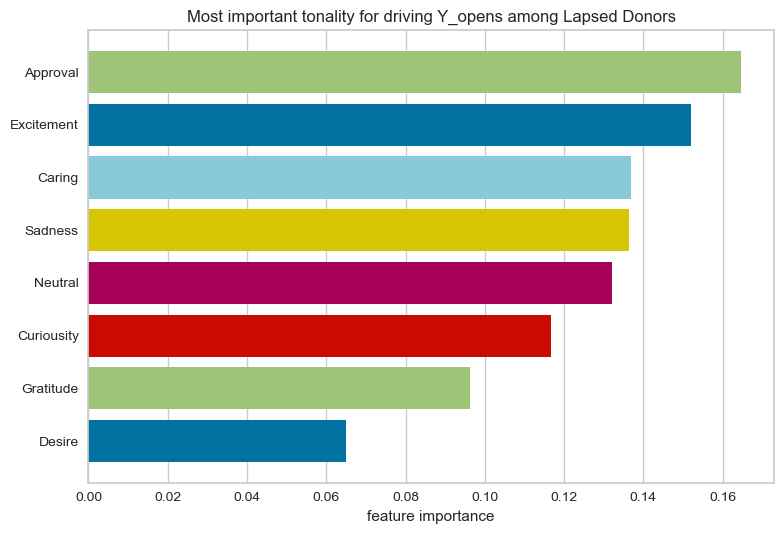

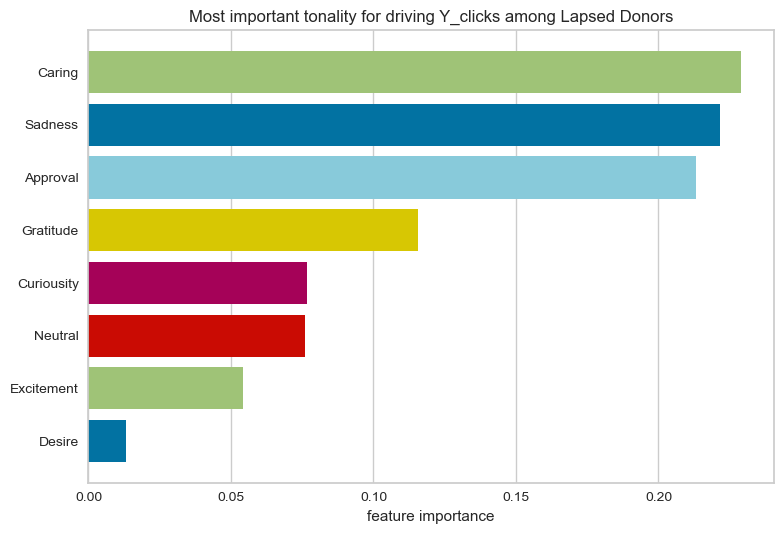

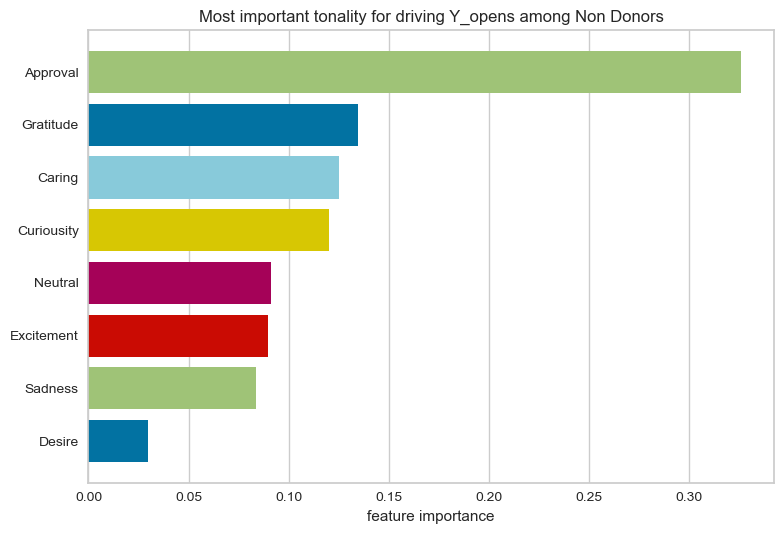

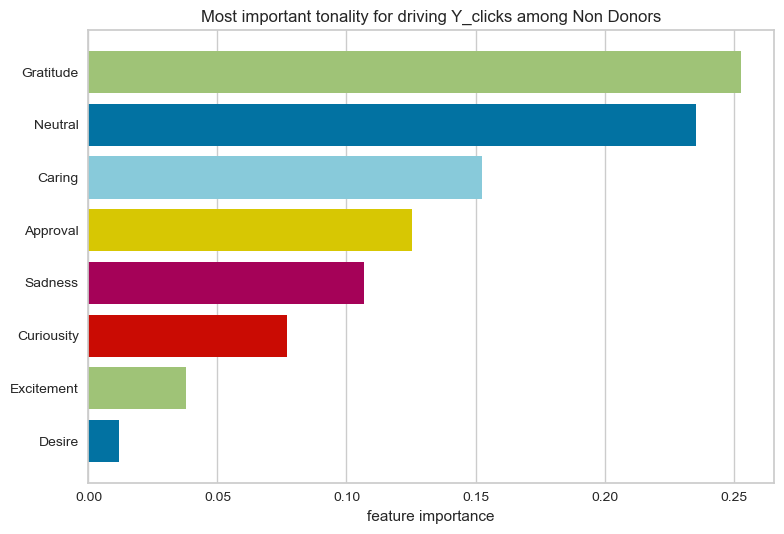

In [42]:
for audience in list_of_audiences:
    
    # creating the subset of audience and campaign to run the model
    data_subset = data_slim[data_slim.audience_new == audience]
    X = pd.concat([data_subset[emotions_list], pd.get_dummies(data_subset.top_factor_label)], axis=1)
    Y_opens = data_subset.target_for_opens
    Y_clicks = data_subset.target_for_clicks
    Y_donations = data_subset.target_for_donations
    target_metrics = [Y_opens, Y_clicks]
    target_metric_names = ['Y_opens', 'Y_clicks']

    for i in range(len(target_metrics)):
        model = RandomForestClassifier()
        title_field="Most important tonality for driving "+str(target_metric_names[i]+" among "+audience)
        viz = FeatureImportances(model, relative=False, title=title_field)
        viz.fit(pd.get_dummies(data_subset.top_factor_label), target_metrics[i])
        viz.show()



This code is so derpy I can't stand it, would be much. more elegatnt to create a function but that's for the next release!

# Appendix

In [43]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])
    
    # Instantiate the classification model and visualizer
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

for model in models:
    score_model(X, Y_opens, model)

SVC: 0.0


ValueError: b'specified nu is infeasible'